In [16]:
import cantera as ct
import os
from rmgpy import chemkin as ck

import argparse
import logging
import math
import os

import matplotlib.pyplot as plt
%matplotlib inline

import
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmg.model import ReactionModel
from rmgpy.rmg.output import save_diff_html

In [2]:
current_model =  "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/baseline/"
good_model = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/base/"

cantera_add = os.path.join("cantera", "chem_annotated.cti")

chem_gas_add = os.path.join("chemkin", "chem_annotated-gas.inp")
chem_surf_add = os.path.join("chemkin", "chem_annotated-surface.inp")
chem_dict_add = os.path.join("chemkin", "species_dictionary.txt")

chem_edge_gas_add = os.path.join("chemkin", "chem_edge_annotated-gas.inp")
chem_edge_surf_add = os.path.join("chemkin", "chem_edge_annotated-surface.inp")
chem_edge_dict_add = os.path.join("chemkin", "species_edge_dictionary.txt")

## load cantera objects

In [3]:
curr_gas_ct = ct.Solution(os.path.join(current_model, cantera_add), "gas")
curr_surf_ct = ct.Interface(os.path.join(current_model, cantera_add), "surface1", [curr_gas_ct])

In [4]:
good_gas_ct = ct.Solution(os.path.join(good_model, cantera_add), "gas")
good_surf_ct = ct.Interface(os.path.join(good_model, cantera_add), "surface1", [good_gas_ct])

## load chemkin models

## Current model 

In [5]:
curr_gas_ck = ck.load_chemkin_file(
    os.path.join(current_model, chem_gas_add),
    os.path.join(current_model, chem_dict_add), 
)
curr_surf_ck = ck.load_chemkin_file(
    os.path.join(current_model, chem_surf_add),
    os.path.join(current_model, chem_dict_add), 
)

In [6]:
curr_edge_gas_ck = ck.load_chemkin_file(
    os.path.join(current_model, chem_edge_gas_add),
    os.path.join(current_model, chem_edge_dict_add), 
)
curr_edge_surf_ck = ck.load_chemkin_file(
    os.path.join(current_model, chem_edge_surf_add),
    os.path.join(current_model, chem_edge_dict_add), 
)

In [7]:
good_gas_ck = ck.load_chemkin_file(
    os.path.join(good_model, chem_gas_add),
    os.path.join(good_model, chem_dict_add), 
)
good_surf_ck = ck.load_chemkin_file(
    os.path.join(good_model, chem_surf_add),
    os.path.join(good_model, chem_dict_add), 
)

In [8]:
good_edge_gas_ck = ck.load_chemkin_file(
    os.path.join(good_model, chem_edge_gas_add),
    os.path.join(good_model, chem_edge_dict_add), 
)
good_edge_surf_ck = ck.load_chemkin_file(
    os.path.join(good_model, chem_edge_surf_add),
    os.path.join(good_model, chem_edge_dict_add), 
)

# Compare gas phase rxns

In [17]:
def compare_model_kinetics(reactions1, reactions2):
    """
    Compare the kinetics of :class:`ReactionModel` objects `model1` and 
    `model2`, printing the results to stdout.
    """
    # Determine reactions that both models have in common
    common_reactions = {}
    for rxn1 in reactions1:
        for rxn2 in reactions2:
            if rxn1.is_isomorphic(rxn2):
                common_reactions[rxn1] = rxn2
                reactions2.remove(rxn2)
                break
    unique_reactions1 = [rxn for rxn in reactions1 if rxn not in list(common_reactions.keys())]
    unique_reactions2 = reactions2

    logging.info('{0:d} reactions were found in both models:'.format(len(common_reactions)))
    for rxn in common_reactions:
        logging.info('    {0!s}'.format(rxn))
    logging.info('{0:d} reactions were only found in the first model:'.format(len(unique_reactions1)))
    for rxn in unique_reactions1:
        logging.info('    {0!s}'.format(rxn))
    logging.info('{0:d} reactions were only found in the second model:'.format(len(unique_reactions2)))
    for rxn in unique_reactions2:
        logging.info('    {0!s}'.format(rxn))

    T = 1000
    P = 1e5
    kinetics1 = []
    kinetics2 = []
    for rxn1, rxn2 in common_reactions.items():
        kinetics1.append(rxn1.get_rate_coefficient(T, P))
        if rxn1.is_isomorphic(rxn2, either_direction=False):
            kinetics2.append(rxn2.get_rate_coefficient(T, P))
        else:
            kinetics2.append(rxn2.get_rate_coefficient(T, P) / rxn2.get_equilibrium_constant(T))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plt.loglog(kinetics1, kinetics2, 'o', picker=5)
    xlim = plt.xlim()
    ylim = plt.ylim()
    lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax.loglog(lim, lim, '--k')
    plt.xlabel('Model 1 rate coefficient (SI units)')
    plt.ylabel('Model 2 rate coefficient (SI units)')
    plt.title('T = {0:g} K, P = {1:g} bar'.format(T, P / 1e5))
    plt.xlim(lim)
    plt.ylim(lim)

    def onpick(event):
        xdata = event.artist.get_xdata()
        ydata = event.artist.get_ydata()
        for ind in event.ind:
            logging.info(list(common_reactions.keys())[ind])
            logging.info('k(T,P) = {0:9.2e} from model 1'.format(xdata[ind]))
            logging.info('k(T,P) = {0:9.2e} from model 2'.format(ydata[ind]))
            logging.info('ratio = 10**{0:.2f}'.format(math.log10(xdata[ind] / ydata[ind])))

    connection_id = fig.canvas.mpl_connect('pick_event', onpick)

    plt.show()

In [26]:
compare_out = os.path.join(os.getcwd(), "ZZ_scratch_compare","gas","gas_model_core")
from rmgpy.tools import diffmodels as dm

dm.save_compare_html(
    compare_out, 
    os.path.join(current_model, chem_gas_add), 
    os.path.join(current_model, chem_dict_add),
    os.path.join(good_model, chem_gas_add), 
    os.path.join(good_model, chem_dict_add),
    read_comments1=True, 
    read_comments2=True,
)

In [28]:
compare_out = os.path.join(os.getcwd(), "ZZ_scratch_compare","surf","surf_model_core")
from rmgpy.tools import diffmodels as dm

dm.save_compare_html(
    compare_out, 
    os.path.join(current_model, chem_surf_add), 
    os.path.join(current_model, chem_dict_add),
    os.path.join(good_model, chem_surf_add), 
    os.path.join(good_model, chem_dict_add),
    read_comments1=True, 
    read_comments2=True,
)

NotImplementedError: Unexpected call to KineticsModel.get_rate_coefficient(); you should be using a class derived from KineticsModel.

/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.


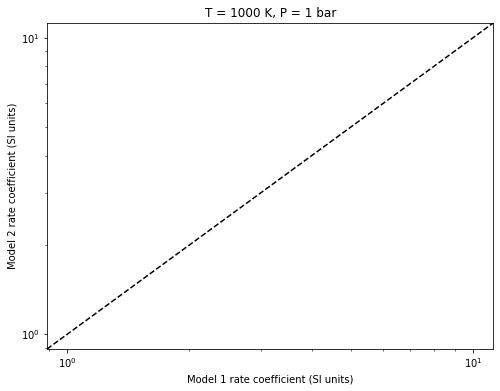

In [18]:
compare_model_kinetics(curr_gas_ck, good_gas_ck)